In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from tqdm import tqdm  # For progress bar

torch.cuda.is_available()

True

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(AlexNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 7 * 7, 4096),  # ajustado para imágenes de 64x64
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [ ]:
#Cargar datos de CIFAR-10 para el reconocimiento de objetos.
# Code for Data Loading and Augmentation
batch_size = 256
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
                                ]) # # Resize images to 227x227 and Convert images to PyTorch tensors

trainset = CIFAR10(root='./CIFAR10_data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = CIFAR10(root='./CIFAR10_data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import torch.optim as optim
# Inicializar modelo, optimizador y función de pérdida
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AlexNet().to(device)

criterion = nn.CrossEntropyLoss() # Loss function
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005, nesterov=True)

print(device)

cuda


In [ ]:
import torch
import time
from tqdm import tqdm
from torch.amp import autocast, GradScaler  # ¡Aquí está la corrección!

# Inicializar el GradScaler
scaler = GradScaler(device="cuda")  # En versiones recientes se debe especificar el dispositivo

start_time = time.time()

# Entrenar modelo desde cero con FP16
epochs = 20
for epoch in range(epochs):
    running_loss = 0.0
    model.train()

    for images, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with autocast(device_type="cuda"):  # Aquí la sintaxis correcta para autocast en PyTorch 2.0+
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()  # Escalar gradientes para evitar problemas de precisión
        scaler.step(optimizer)  # Optimización del modelo
        scaler.update()  # Actualizar el escalado dinámico

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

    # Evaluar el modelo en el conjunto de prueba
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            with autocast(device_type="cuda"):  # Evaluación en FP16 con la nueva sintaxis
                outputs = model(images)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy after Epoch {epoch+1}: {accuracy:.2f}%")

# Medir tiempo de ejecución
end_time = time.time()
execution_time = end_time - start_time
execution_time /= 60  # Convertir a minutos
print(f"Tiempo de ejecución de la celda anterior: {execution_time:.2f} minutos")

# Guardar los pesos del modelo
torch.save(model.state_dict(), "alexnet_cifar10_fp16.pth")


Epoch 1: 100%|██████████| 196/196 [01:01<00:00,  3.16it/s]


Epoch 1, Loss: 1.1907
Test Accuracy after Epoch 1: 50.56%


Epoch 2: 100%|██████████| 196/196 [01:01<00:00,  3.17it/s]


Epoch 2, Loss: 1.0558
Test Accuracy after Epoch 2: 61.43%


Epoch 3: 100%|██████████| 196/196 [01:02<00:00,  3.16it/s]


Epoch 3, Loss: 1.1521
Test Accuracy after Epoch 3: 67.28%


Epoch 4: 100%|██████████| 196/196 [01:01<00:00,  3.20it/s]


Epoch 4, Loss: 1.0185
Test Accuracy after Epoch 4: 63.13%


Epoch 5: 100%|██████████| 196/196 [01:01<00:00,  3.20it/s]


Epoch 5, Loss: 0.6579
Test Accuracy after Epoch 5: 72.32%


Epoch 6: 100%|██████████| 196/196 [01:01<00:00,  3.18it/s]


Epoch 6, Loss: 0.5386
Test Accuracy after Epoch 6: 77.94%


Epoch 7: 100%|██████████| 196/196 [01:00<00:00,  3.22it/s]


Epoch 7, Loss: 0.6901
Test Accuracy after Epoch 7: 77.03%


Epoch 8: 100%|██████████| 196/196 [01:01<00:00,  3.21it/s]


Epoch 8, Loss: 0.5721
Test Accuracy after Epoch 8: 78.85%


Epoch 9: 100%|██████████| 196/196 [01:00<00:00,  3.22it/s]


Epoch 9, Loss: 0.3200
Test Accuracy after Epoch 9: 79.58%


Epoch 10: 100%|██████████| 196/196 [01:00<00:00,  3.22it/s]


Epoch 10, Loss: 0.7250
Test Accuracy after Epoch 10: 80.69%


Epoch 11: 100%|██████████| 196/196 [01:01<00:00,  3.19it/s]


Epoch 11, Loss: 0.4024
Test Accuracy after Epoch 11: 81.78%


Epoch 12: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s]


Epoch 12, Loss: 0.3642
Test Accuracy after Epoch 12: 80.70%


Epoch 13: 100%|██████████| 196/196 [01:01<00:00,  3.19it/s]


Epoch 13, Loss: 0.2960
Test Accuracy after Epoch 13: 84.40%


Epoch 14: 100%|██████████| 196/196 [01:00<00:00,  3.23it/s]


Epoch 14, Loss: 0.1865
Test Accuracy after Epoch 14: 85.41%


Epoch 15: 100%|██████████| 196/196 [01:00<00:00,  3.24it/s]


Epoch 15, Loss: 0.3068
Test Accuracy after Epoch 15: 84.92%


Epoch 16: 100%|██████████| 196/196 [01:01<00:00,  3.20it/s]


Epoch 16, Loss: 0.2807
Test Accuracy after Epoch 16: 84.47%


Epoch 17: 100%|██████████| 196/196 [01:00<00:00,  3.24it/s]


Epoch 17, Loss: 0.1468
Test Accuracy after Epoch 17: 85.29%


Epoch 18: 100%|██████████| 196/196 [01:01<00:00,  3.18it/s]


Epoch 18, Loss: 0.2651
Test Accuracy after Epoch 18: 85.46%


Epoch 19: 100%|██████████| 196/196 [01:02<00:00,  3.16it/s]


Epoch 19, Loss: 0.1908
Test Accuracy after Epoch 19: 84.03%


Epoch 20: 100%|██████████| 196/196 [01:01<00:00,  3.18it/s]


Epoch 20, Loss: 0.1903
Test Accuracy after Epoch 20: 85.92%
Tiempo de ejecución de la celda anterior: 22.80 minutos


In [ ]:
"""start_time = time.time()
# Entrenar modelo desde cero
epochs = 25
for epoch in range(epochs):  # Entrenar épocas para prueba
    running_loss = 0.0
    model.train()
    for images, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()  # Accumulate loss

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Evaluate the model on the test set after each epoch
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy after Epoch {epoch+1}: {accuracy:.2f}%")

result = sum(range(1000000))
end_time = time.time()
execution_time = end_time - start_time
print(f"Tiempo de ejecución de la celda anterior: {execution_time} segundos")

# Save the trained model weights
#torch.save(model.state_dict(), "alexnet_cifar10.pth")

In [ ]:
# Test the network on the test data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

Accuracy of the network on the 10000 test images: 86.31 %


In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Class-wise accuracy
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print(f'Accuracy of {classes[i]:5s} : {100 * class_correct[i] / class_total[i]:.2f} %')

Accuracy of plane : 93.75 %
Accuracy of car   : 92.31 %
Accuracy of bird  : 84.62 %
Accuracy of cat   : 63.64 %
Accuracy of deer  : 53.85 %
Accuracy of dog   : 80.00 %
Accuracy of frog  : 66.67 %
Accuracy of horse : 83.33 %
Accuracy of ship  : 90.48 %
Accuracy of truck : 88.24 %


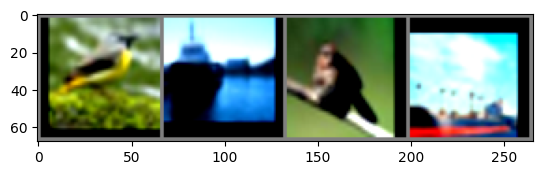

 bird || ship || bird || ship


In [ ]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
def imageshow(image):
  # un-normalize the image
   image = image/2 + 0.5
   npimage = image.numpy()
   plt.imshow(np.transpose(npimage, (1, 2, 0)))
   plt.show()

# sample images from training set
dataiter = iter(trainloader)
images, labels = next(dataiter)
# display images in a grid
num_images = 4
imageshow(torchvision.utils.make_grid(images[:num_images]))
# print labels
print(' ' + ' || '.join(classes[labels[j]]
        for j in range(num_images)))



In [ ]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_params( model )

71926858

In [ ]:
# Guardar el modelo entrenado en Google Drive
model_path = '/content/drive/My Drive/alexnet_cifar10_fp16.pth"'
torch.save(model.state_dict(), model_path)


In [ ]:


 #!ls '/content/drive/My Drive/'


In [ ]:
# Guardar el modelo en el sistema de archivos de Colab
#model_path = '/content/alexnet_cifar10.pth'
#torch.save(model.state_dict(), model_path)


In [ ]:
#from google.colab import files
#files.download(model_path)
